In [ ]:
#for timing purporses
!pip install ipython-autotime

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.08 s (started: 2021-01-08 23:00:09 +00:00)


## **UNet for Cell Segmentation**
Unet by Sreenivas Bhattiprolu from Python for Microscopists.

In [ ]:
import tensorflow as tf
import os
import random
import numpy as np
import cv2
 
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

time: 2.07 ms (started: 2021-01-08 23:00:11 +00:00)


###U-Net Diagram


### **1. Setting up the Input Images (images, binary masks)**

#### **1.1 Create Training and Testing Datasets**

In [ ]:
!pip install imagecodecs

time: 2.07 s (started: 2021-01-08 23:00:11 +00:00)


In [ ]:
def load_images_path_from_folder(folder):
    imagespath = []
    for filename in tqdm(os.listdir(folder)):
        imgpath = os.path.join(folder,filename)
        if imread(imgpath) is not None:
            imagespath.append(imgpath)
    imagespath.sort()
    return imagespath


seed = 42
np.random.seed = seed

IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1

TRAIN_PATH_01 = '/content/drive/MyDrive/dataset/unet/Fluo-N2DH-GOWT1/Training/01'
TRAIN_PATH_01_MASK = '/content/drive/MyDrive/dataset/unet/Fluo-N2DH-GOWT1/Training/01_STMSK/SEG'
TRAIN_PATH_02 = '/content/drive/MyDrive/dataset/unet/Fluo-N2DH-GOWT1/Training/02'
TRAIN_PATH_02_MASK = '/content/drive/MyDrive/dataset/unet/Fluo-N2DH-GOWT1/Training/02_STMSK/SEG'

TEST_PATH_01 = '/content/drive/MyDrive/dataset/unet/Fluo-N2DH-GOWT1/Testing/01'
TEST_PATH_02 = '/content/drive/MyDrive/dataset/unet/Fluo-N2DH-GOWT1/Testing/02'

train_filepaths_images = load_images_path_from_folder(TRAIN_PATH_01)+load_images_path_from_folder(TRAIN_PATH_02)
train_filepaths_masks = load_images_path_from_folder(TRAIN_PATH_01_MASK)+load_images_path_from_folder(TRAIN_PATH_02_MASK)

test_filepaths_images = load_images_path_from_folder(TEST_PATH_01)+load_images_path_from_folder(TEST_PATH_02)

X_train = np.zeros((len(train_filepaths_images), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_filepaths_masks), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

100%|██████████| 20/20 [00:00<00:00, 204.29it/s]

time: 1.56 s (started: 2021-01-08 23:00:14 +00:00)


#### **1.2 Preprocessing of the images**

The images are preprocessed (resizing)

Starting with training images

In [ ]:
#from google.colab.patches import cv2_imshow
print('Resizing training images and masks')
for n, image_file in tqdm(enumerate(train_filepaths_images), total=len(train_filepaths_images)):   
    img = imread(image_file)
    img = np.expand_dims(resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis = -1)
    X_train[n] = img  #Fill empty X_train with values from img

for n, mask_file in tqdm(enumerate(train_filepaths_masks), total=len(train_filepaths_masks)):
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_ = imread(mask_file)
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)  
    Y_train[n] = mask

print('Done!')

  4%|▍         | 6/134 [00:00<00:02, 58.82it/s]

Resizing training images and masks


100%|██████████| 134/134 [00:02<00:00, 62.75it/s]

Done!
time: 4.36 s (started: 2021-01-08 23:00:15 +00:00)


Then the testing images

In [ ]:
# test images
X_test = np.zeros((len(test_filepaths_images), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, test_image in tqdm(enumerate(test_filepaths_images), total=len(test_filepaths_images)):
    img = imread(test_image)
    sizes_test.append([img.shape[0], img.shape[1]])
    img = np.expand_dims(resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis = -1)
    X_test[n] = img

print('Done!')

 12%|█▏        | 6/50 [00:00<00:00, 58.80it/s]

Resizing test images


100%|██████████| 50/50 [00:00<00:00, 60.57it/s]

Done!
time: 841 ms (started: 2021-01-08 22:58:14 +00:00)


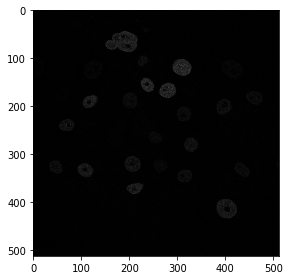

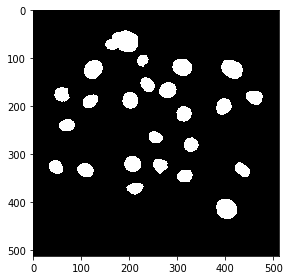

time: 387 ms (started: 2021-01-08 22:58:15 +00:00)


In [ ]:
image_x = random.randint(0, len(train_filepaths_images))
imshow(np.squeeze(X_train[image_x]))
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

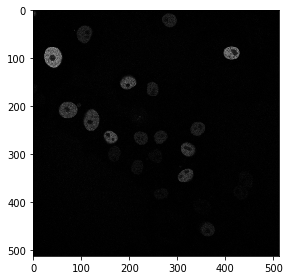

time: 176 ms (started: 2021-01-08 22:58:16 +00:00)


In [ ]:
image_t = random.randint(0, len(test_filepaths_images))
imshow(np.squeeze(X_test[image_t]))
plt.show()

## **2. The UNet model**

In [ ]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512, 512, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 160         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

## **3. Model checkpoint and fitting of training data**

In [ ]:

################################
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/COMP700/UNet_Model/model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=2, epochs=50, callbacks=callbacks)

Epoch 1/50
60/60 [==============================] - 14s 84ms/step - loss: 0.4513 - accuracy: 0.8532 - val_loss: 0.0864 - val_accuracy: 0.9777
Epoch 2/50
60/60 [==============================] - 4s 74ms/step - loss: 0.0421 - accuracy: 0.9885 - val_loss: 0.0578 - val_accuracy: 0.9853
Epoch 3/50
60/60 [==============================] - 4s 74ms/step - loss: 0.0286 - accuracy: 0.9913 - val_loss: 0.0255 - val_accuracy: 0.9909
Epoch 4/50
60/60 [==============================] - 4s 74ms/step - loss: 0.0155 - accuracy: 0.9942 - val_loss: 0.0236 - val_accuracy: 0.9917
Epoch 5/50
60/60 [==============================] - 4s 74ms/step - loss: 0.0149 - accuracy: 0.9945 - val_loss: 0.0240 - val_accuracy: 0.9913
Epoch 6/50
60/60 [==============================] - 4s 75ms/step - loss: 0.0128 - accuracy: 0.9952 - val_loss: 0.0205 - val_accuracy: 0.9927
Epoch 7/50
60/60 [==============================] - 4s 75ms/step - loss: 0.0117 - accuracy: 0.9955 - val_loss: 0.0204 - val_accuracy: 0.9922
Epoch 8/50
6

### **4. Test results**

2/2 [==============================] - 2s 2s/step


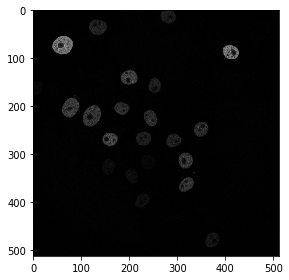

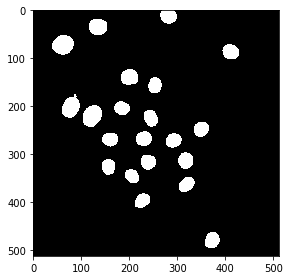

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


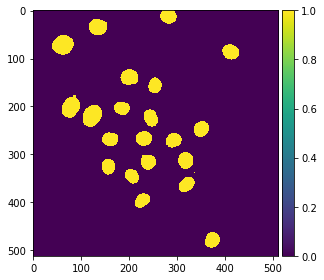

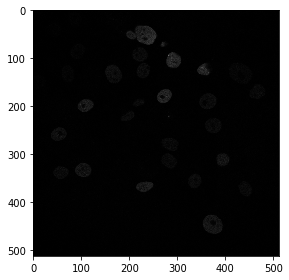

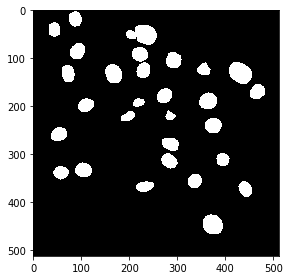

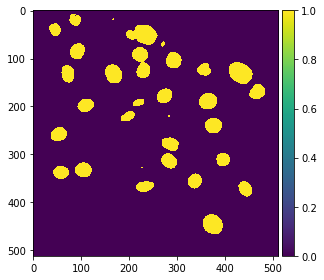

time: 8.72 s (started: 2021-01-08 22:59:17 +00:00)


In [ ]:
####################################

idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(np.squeeze(X_train[ix]))
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(np.squeeze(X_train[int(X_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

##**5. Save the test images**

In [ ]:
#To image 
test_images = [np.squeeze(img) for img in preds_test_t]

# from range [0, 1] to [0, 255] binary image
test_images2 = []
for image in tqdm(test_images):
  for i in range(len(image)):
    for j in range(len(image[i])):
      image[i][j]=image[i][j]*255
  test_images2.append(image)



100%|██████████| 50/50 [00:33<00:00,  1.50it/s]

time: 33.4 s (started: 2021-01-08 22:59:25 +00:00)


In [ ]:
test_num_01 = []
test_num_02 = []


for testimage in os.listdir(TEST_PATH_01):
  test_num_01.append(testimage[1]+testimage[2]+testimage[3])

for testimage in os.listdir(TEST_PATH_02):
  test_num_02.append(testimage[1]+testimage[2]+testimage[3])

test_num_01.sort()
test_num_02.sort()

for i in tqdm(range(len(test_num_01))):
  path = '/content/drive/MyDrive/dataset/unet/Fluo-N2DH-GOWT1/Testing/01_RES/'+'mask'+test_num_01[i]+'.tif'
  cv2.imwrite(path, test_images2[i])
  
for j in tqdm(range(len(test_num_02))):
  path = '/content/drive/MyDrive/dataset/unet/Fluo-N2DH-GOWT1/Testing/02_RES/'+'mask'+test_num_02[j]+'.tif'
  cv2.imwrite(path, test_images2[j+30])

100%|██████████| 20/20 [00:00<00:00, 112.73it/s]

time: 2.67 s (started: 2021-01-08 23:05:59 +00:00)


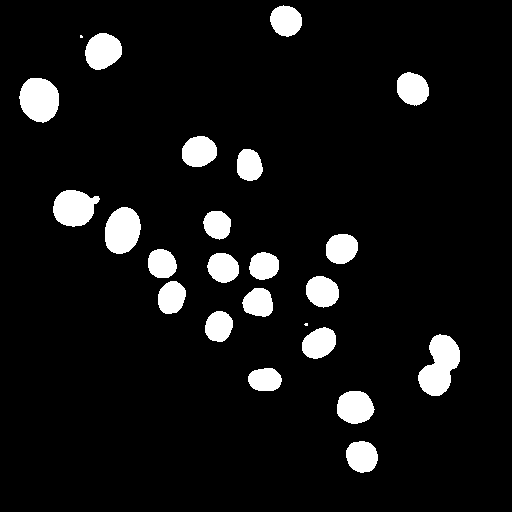

time: 27.9 ms (started: 2021-01-08 23:00:07 +00:00)


In [ ]:
from google.colab.patches import cv2_imshow

cv2_imshow(test_images2[2])